# Состав команды
### Ячменьков Алексей:
#### Загрузка, обработка, подготовка данных
##### 
### Баранов Владислав:
#### Загрузка и обработка наших фото, предсказания фото
#####
### Аллабердин Богдан:
#### подготовка модели и обучение

In [1]:
import os
from pathlib import Path

import os
import cv2
import wandb
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tqdm.notebook import tnrange

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from PIL import Image

from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization

# create train test

In [35]:
def preprocessing_source_photos(source_folder, destination_folder):
    mtcnn = MTCNN(image_size=160)

    for image_name in os.listdir(source_folder):
        image_path = os.path.join(source_folder, image_name)
        image = Image.open(image_path)
        image = mtcnn(image)

        if image is not None:
            image = torch.Tensor(cv2.normalize(image.numpy(), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)).permute(1,2,0)
            image = torch.Tensor(cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR))
            cv2.imwrite(os.path.join(destination_folder, image_name), image.numpy() * 255)

        else:
            image = torch.Tensor(cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(source_folder, image_name)), cv2.COLOR_RGB2BGR), (160, 160)))
            image = cv2.normalize(image.numpy(), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            cv2.imwrite(os.path.join(destination_folder, image_name), image * 255)

In [68]:
preprocessing_source_folder = './img_align_celeba'
preprocessing_destination_folder = './img_align_celeba_mtcnn'

preprocessing_source_photos(preprocessing_source_folder, preprocessing_destination_folder)

In [4]:
def read_txt_file_to_dict(file_path, num_th=10):
    result_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            photos_name, index = line.strip().split()
                     
            if index not in result_dict:
                result_dict[index] = []
            result_dict[index].append(photos_name)
            
    for index in list(result_dict.keys()):
        if len(result_dict[index]) < num_th:
            del result_dict[index]
            
    return result_dict

In [5]:
def make_train_and_test_folders(index_to_photos_name_dict, source_folder, train_folder='train', test_folder='test', test_size=0.2):
    output_train_directory = os.path.join(os.getcwd(), train_folder)
    output_test_directory = os.path.join(os.getcwd(), test_folder)
    
    os.makedirs(output_train_directory, exist_ok=True)
    os.makedirs(output_test_directory, exist_ok=True)
    
    indexes = list(index_to_photos_name_dict.keys())
    train_indexes, test_indexes = train_test_split(indexes, test_size=test_size, shuffle=True)
    
    def copy_files(indexes, destination_folder):
        for index in indexes:
            photos_name = index_to_photos_name_dict[index]
            index_folder = os.path.join(destination_folder, index)
            os.makedirs(index_folder, exist_ok=True)
            for photo_name in photos_name:
                source_path = os.path.join(source_folder, photo_name)
                destination_path = os.path.join(index_folder, photo_name)
                shutil.copy(source_path, destination_path)
                
    copy_files(train_indexes, output_train_directory)
    copy_files(test_indexes, output_test_directory)

In [6]:
def read_celeba_images(images_directory_path):
    datax = []
    datay = []
    
    for image in os.listdir(images_directory_path):
        if image.endswith('.jpg'):
            image_path = os.path.join(images_directory_path, image)
            
            datax.append(image_path)
            datay.append(images_directory_path)
            
    return np.array(datax), np.array(datay)

In [7]:
cv2.imread(os.path.join(os.getcwd(), 'test/3/045833.jpg'))

array([[[233, 238, 236],
        [232, 237, 235],
        [229, 234, 232],
        ...,
        [ 37,  51,  50],
        [ 79,  93,  91],
        [107, 121, 119]],

       [[234, 239, 237],
        [233, 238, 236],
        [229, 234, 232],
        ...,
        [ 87, 101, 100],
        [100, 114, 112],
        [112, 126, 124]],

       [[236, 241, 239],
        [234, 239, 237],
        [230, 235, 233],
        ...,
        [100, 113, 111],
        [ 88, 101,  99],
        [ 80,  93,  91]],

       ...,

       [[162, 181, 194],
        [158, 177, 190],
        [151, 170, 183],
        ...,
        [ 63,  93, 152],
        [ 62,  91, 152],
        [ 62,  91, 152]],

       [[153, 171, 182],
        [147, 165, 176],
        [136, 154, 165],
        ...,
        [ 61,  91, 150],
        [ 61,  90, 151],
        [ 60,  89, 150]],

       [[130, 146, 158],
        [122, 138, 150],
        [107, 123, 135],
        ...,
        [ 59,  89, 148],
        [ 58,  87, 148],
        [ 58,  87, 148]]

In [7]:
def read_images(base_directory):
    datax = None
    datay = None
    
    results = [read_celeba_images(base_directory + '/' + directory + '/') for directory in os.listdir(base_directory)]
    
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.concatenate([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [98]:
txt_file_path = './identity_CelebA.txt'

index_to_photos_name_dict = read_txt_file_to_dict(txt_file_path)

In [99]:
make_train_and_test_folders(index_to_photos_name_dict, './img_align_celeba_mtcnn')

In [8]:
trainx, trainy = read_images('./train')

In [9]:
testx, testy = read_images('./test')

In [10]:
trainy

array(['./train/1/', './train/1/', './train/1/', ..., './train/9997/',
       './train/9997/', './train/9997/'], dtype='<U14')

In [11]:
testx

array(['./test/10003/006760.jpg', './test/10003/011693.jpg',
       './test/10003/019741.jpg', ..., './test/9998/136177.jpg',
       './test/9998/148348.jpg', './test/9998/157994.jpg'], dtype='<U23')

In [12]:
def extract_sample(n_way, n_support, n_query, datax, datay):

    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support + n_query)]
        sample.append([cv2.cvtColor(cv2.imread(fname), cv2.COLOR_RGB2BGR)/255 for fname in sample_cls])

    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0, 1, 4, 2, 3)
    return ({
        'images': sample,
        'targets': K,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })

In [13]:
def display_sample(sample):
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])

    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0))

['./train/7519/' './train/9253/' './train/4912/' './train/5948/'
 './train/2755/']


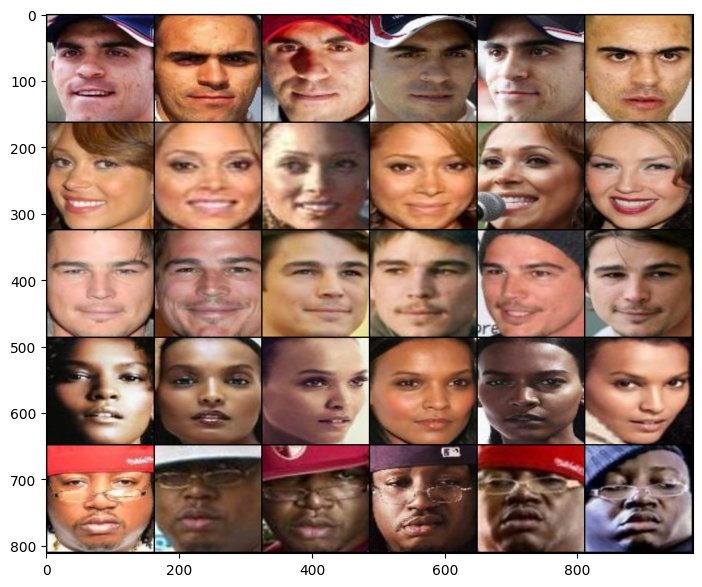

In [14]:
sample_example = extract_sample(5, 3, 3, trainx, trainy)
display_sample(sample_example['images'])
print(sample_example['targets'])

In [17]:
sample_example['images'].shape

torch.Size([5, 6, 3, 160, 160])

In [18]:
torch.cuda.is_available()

False

## Build model

In [19]:
class ProtoNet(nn.Module):
    def __init__(self, device='cuda'):
        super(ProtoNet, self).__init__()
        self.device = device
        self.encoder = InceptionResnetV1(pretrained='vggface2').to(self.device)

    def set_forward_loss(self, sample):
        sample_images = sample['images']
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        sample_images = sample_images.to(self.device)
        sample_images = sample_images.view(n_way * (n_support + n_query), *sample_images.shape[-3:])

        # img2vec results
        vectors = self.encoder(sample_images).view(n_way, (n_support + n_query), -1)

        # центры тяжести класстеров классов
        prototypes = vectors[:, :n_support].mean(1)

        # ищем расстояния от каждого изображения из query до каждого центра тяжести
        queries = vectors[:, n_support:].contiguous().view(-1, vectors.shape[-1])
        query_dists = list()
        for query in queries:
            prototype_dists = torch.stack([torch.sqrt(torch.pow(query - prototype, 2).sum()) for prototype in prototypes])
            query_dists.append(prototype_dists)
        query_dists = torch.stack(query_dists)

        probabilities = F.log_softmax(-query_dists, dim=1).view(n_way, n_query, -1)

        probability, y_hat = probabilities.max(2)

        losses = list()
        n_true_positive = 0
        for way in range(n_way):
            for query in range(n_query):
                losses.append(-probabilities[way][query][way])
                if y_hat[way][query] == way:
                    n_true_positive += 1
        loss_val = torch.stack(losses).mean()
        acc = n_true_positive / (n_way * n_query)

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc,
            'y_hat': y_hat,
            'probability': probability
            }

## Train

In [20]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    if wandb.run is not None:
        wandb.watch(model)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0 
    stop = False 

    train_losses = []
    train_acc = []
    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch + 1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)
        
        if wandb.run is not None:
            wandb.log({'Epoch': epoch + 1, 'Loss': round(epoch_loss, 4), 'Acc': round(epoch_acc, 4)})
        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        epoch += 1
        scheduler.step()
    torch.save(model.state_dict(), "new_model.pt")
    return train_losses, train_acc

In [21]:
should_log = False

model = ProtoNet(device='cuda')

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_way = 20
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000

In [22]:
from show_train_res import plot_losses

In [21]:
torch.cuda.empty_cache()

In [22]:
%%time
if should_log:
    wandb.init(project='homework', name='baseline')
loss, acc = train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

Epoch 1 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1 -- Loss: 2.2242 Acc: 0.5605


Epoch 2 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 2 -- Loss: 2.1310 Acc: 0.6667


Epoch 3 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 3 -- Loss: 2.0757 Acc: 0.7209


Epoch 4 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 4 -- Loss: 2.0319 Acc: 0.7623


Epoch 5 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 5 -- Loss: 2.0010 Acc: 0.7959
CPU times: total: 1h 29min 1s
Wall time: 1h 45min 11s


## Графики обучения ProtoNet

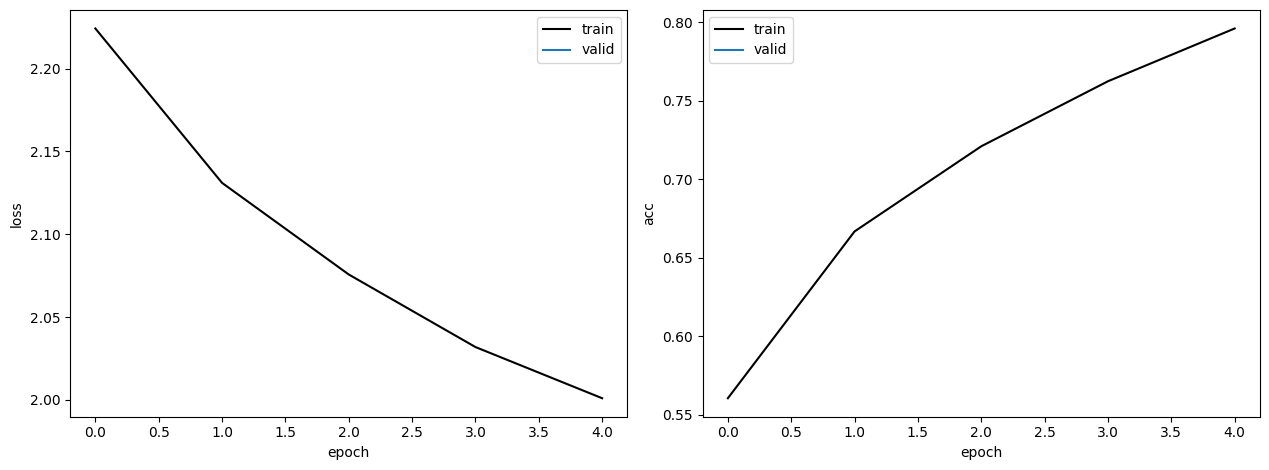

In [24]:
plot_losses(np.array([loss, acc]), np.array([[],[]]), 'loss', 'acc')

## Test

In [25]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    if wandb.run is not None:
        wandb.watch(model)
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']

    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    if wandb.run is not None:
        wandb.log({'n_way': n_way, 'k_shot': n_support})
        wandb.log({'Test loss': round(avg_loss, 4), 'Test acc': round(avg_acc, 4), 'n_way': n_way, 'k_shot': n_support})
    return [avg_loss, avg_acc]

In [28]:
n_way = 5
n_support = 1
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

model = ProtoNet(device='cuda')
model.load_state_dict(torch.load('./new_model.pt'))

<All keys matched successfully>

In [29]:
print('test: 5-way 1-shot')
output = test(model, test_x, test_y, 5, 1, n_query, test_episode)
print(f'loss: {output[0]}, acc: {output[1]}')
if wandb.run is not None:
    wandb.finish()

test: 5-way 1-shot


  0%|          | 0/1000 [00:00<?, ?it/s]

loss: 0.9825659051537514, acc: 0.8015599999999972


## Prediction on our images

In [36]:
preprocessing_source_folder = './our_images'
preprocessing_destination_folder = './our_images_mtcnn'

preprocessing_source_photos(preprocessing_source_folder, preprocessing_destination_folder)

In [190]:
from random import sample as r_sample

In [221]:
def create_custom_sample(n_query, n_detect, test_x, test_y, person_folder):
    target = person_folder.split('/')[-1]
    
    image_paths = list()
    for image in os.listdir(person_folder):
        if image.endswith('.jpg'):
            image_paths.append(os.path.join(person_folder, image))
    
    if n_detect + 1 > len(image_paths):
        n_detect = len(image_paths) - 1
    image_paths = r_sample(image_paths, n_detect + 1)
    images = [cv2.cvtColor(cv2.imread(fname), cv2.COLOR_RGB2BGR)/255 for fname in image_paths]
    for i in range(len(images)):
        images[i] = torch.tensor(images[i]).float().permute(2, 0, 1)

    sample = extract_sample(n_query, 1, 0, test_x, test_y)
    custom_sample = dict()
    custom_sample['n_way'] = 1
    custom_sample['n_support'] = 1
    custom_sample['n_query'] = n_query + n_detect
    custom_sample['targets'] = target
    for i in range(n_query):
        images.append(sample['images'][i][0])
        
    images = torch.stack(images).unsqueeze(0)
    custom_sample['images'] = images
    return custom_sample

In [120]:
class DetectingProtoNet(nn.Module):
    def __init__(self, encoder, device='cuda'):
        super(DetectingProtoNet, self).__init__()
        self.device = device
        self.encoder = encoder

    def set_forward_loss(self, sample):
        sample_images = sample['images']
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        sample_images = sample_images.to(self.device)
        sample_images = sample_images.view(n_way * (n_support + n_query), *sample_images.shape[-3:])

        # img2vec results
        vectors = self.encoder(sample_images).view(n_way, (n_support + n_query), -1)

        # центры тяжести класстеров классов
        prototypes = vectors[:, :n_support].mean(1)

        # ищем расстояния от каждого изображения из query до каждого центра тяжести
        queries = vectors[:, n_support:].contiguous().view(-1, vectors.shape[-1])
        query_dists = list()
        for query in queries:
            prototype_dists = torch.stack([torch.sqrt(torch.pow(query - prototype, 2).sum()) for prototype in prototypes])
            query_dists.append(prototype_dists)
        query_dists = torch.stack(query_dists).squeeze()
        
        return torch.sigmoid(-query_dists).to('cpu').detach().numpy()

In [258]:
def predict(model, input_sample):
    with torch.inference_mode():
        output = model.set_forward_loss(input_sample)
        th = 0.28
        sample = input_sample['images']
        sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
        out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1], )

        name = input_sample['targets']
        labels = ['support'] + [name if probability > th else f'not {name}' for probability in output]
        
    fig = plt.figure(figsize=(15, 7))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(len(sample[0])):
        ax = fig.add_subplot(5, 13, i + 1, xticks=[], yticks=[])
        ax.imshow(sample_4D[i].permute(1, 2, 0))
        ax.text(0, -10, labels[i], fontsize = 10)


In [ ]:
detecting_model = DetectingProtoNet(model.encoder)

### Алексей

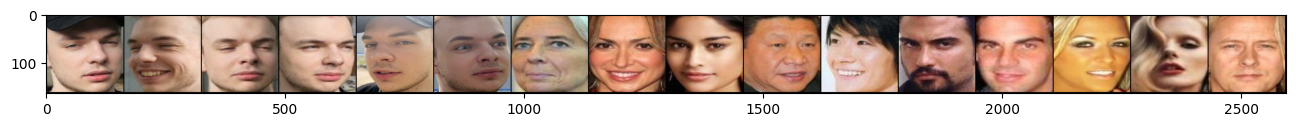

In [270]:
sample = create_custom_sample(10, 5, test_x, test_y, './our_images_mtcnn/Alex')
sample['images'].size(), sample['targets']
display_sample(sample['images'])

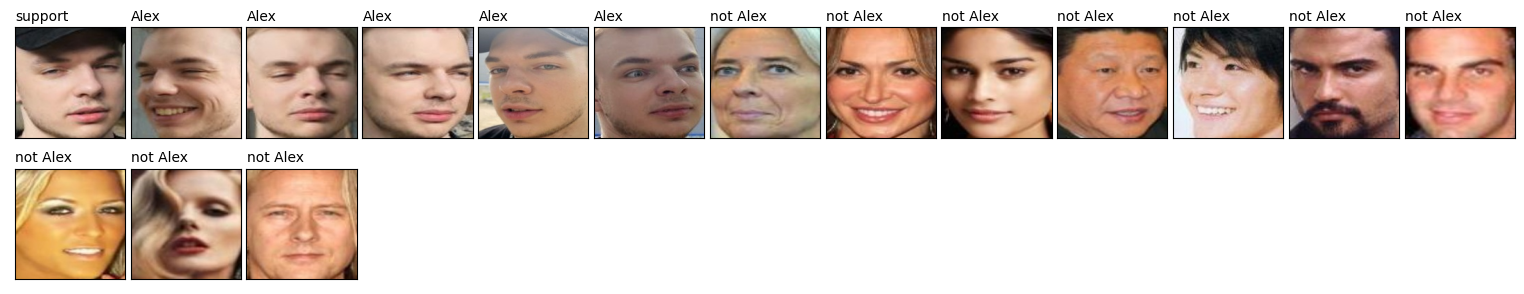

In [271]:
predict(detecting_model, sample)

### Влад

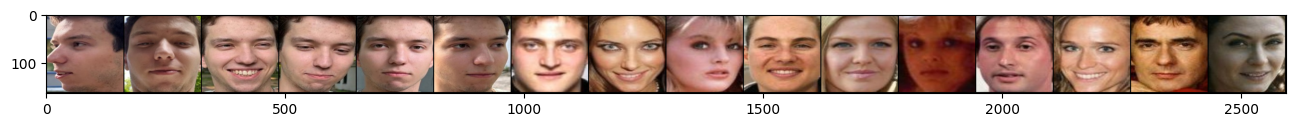

In [272]:
sample = create_custom_sample(10, 5, test_x, test_y, './our_images_mtcnn/Vlad')
sample['images'].size(), sample['targets']
display_sample(sample['images'])

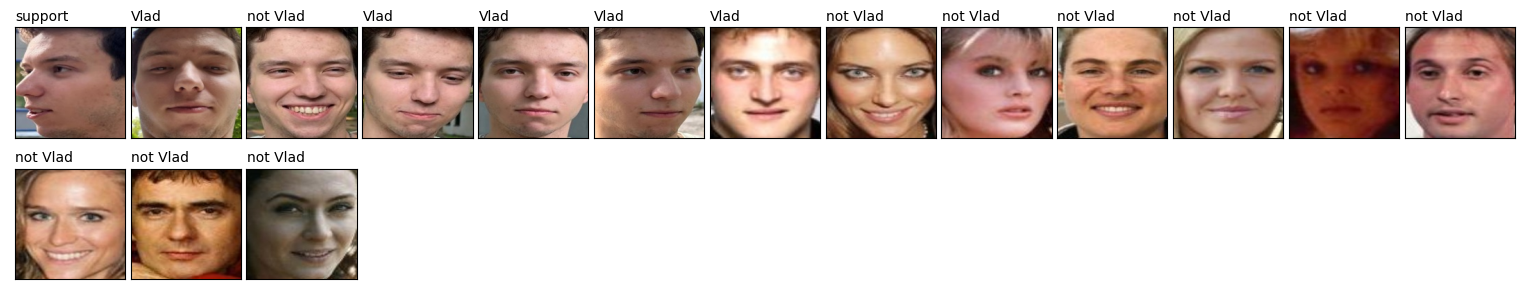

In [273]:
predict(detecting_model, sample)

### Богдан

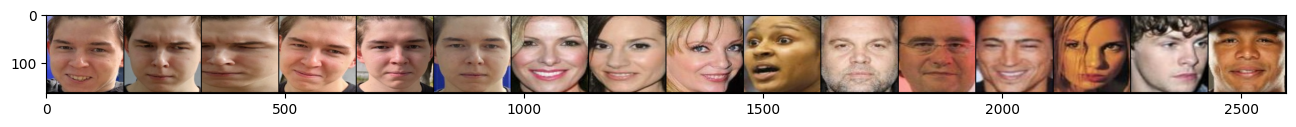

In [292]:
sample = create_custom_sample(10, 5, test_x, test_y, './our_images_mtcnn/Bogdan')
sample['images'].size(), sample['targets']
display_sample(sample['images'])

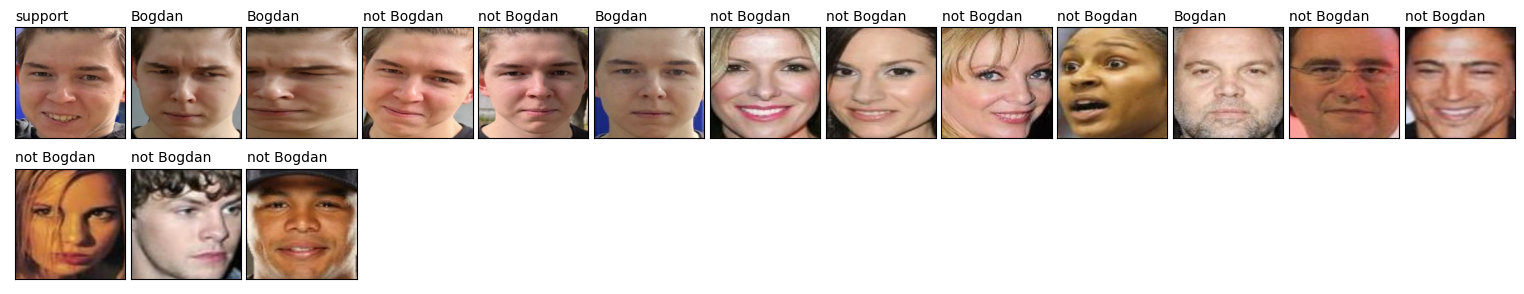

In [295]:
predict(detecting_model, sample)